# CLIP + SAM

In [1]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
#import clip
import torch
import numpy as np

In [2]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint="sam_vit_h_4b8939.pth"))

In [3]:
image_path = "assets/endo.jpg"# "assets/example-image.jpg"

In [4]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

In [5]:
image.shape

(705, 881, 3)

In [6]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [7]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)

    segmented_image_array = np.zeros_like(image_array)
    
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)

    black_image = Image.new("RGB", image.size, (0, 0, 0))

    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')

    black_image.paste(segmented_image, mask=transparency_mask_image)
    
    return black_image

In [8]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [9]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model, preprocess = clip.load("ViT-B/32", device=device)
import open_clip
open_clip.pretrained.list_pretrained()
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip', device=device)
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')

In [10]:
@torch.no_grad()

def retriev(elements: list[Image.Image], search_text) -> int:
    # Preprocess the images and text
    preprocessed_images = [preprocess_train(image).to(device) for image in elements]

    tokenized_text = tokenizer(search_text) #clip.tokenize([search_text]).to(device)
    # Encode the images and text
    stacked_images = torch.stack(preprocessed_images)
    
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    # Calculate the similarity
    probs = 100. * image_features @ text_features.T

    return probs[:, 0].softmax(dim=0)

In [11]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

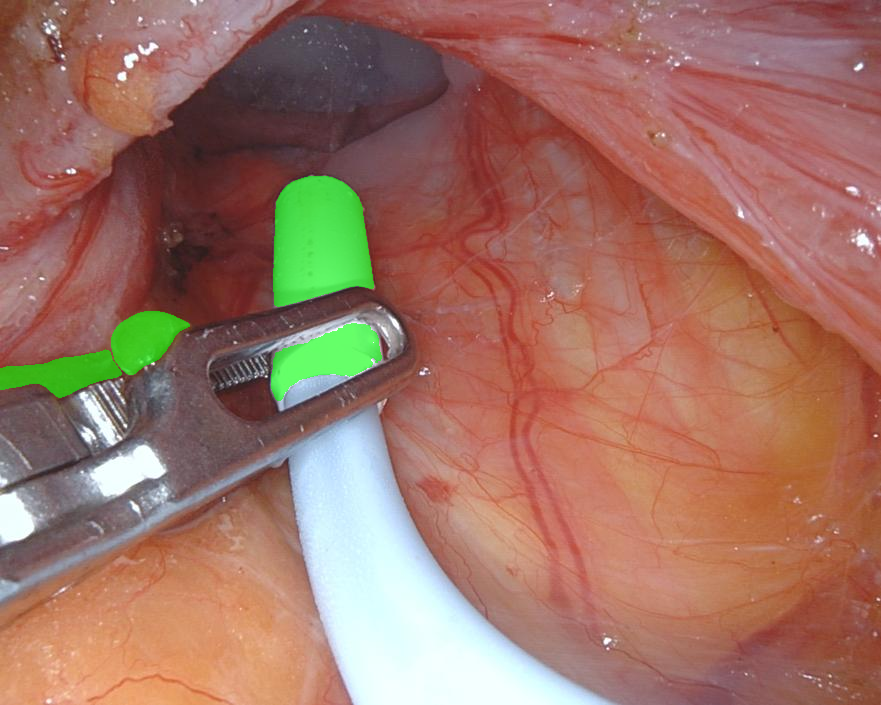

In [12]:
#obj = "catheter"
# "prograsp_forceps": [
# "prograsp forceps",
obj = "surgical instrument prograsp forceps."
#"prograsp forceps possess curved scissor-like handles, specialized grasping tips with interlocking jaws, a ratcheting mechanism, and color-coded markings for easy identification during surgery.",

scores = retriev(cropped_boxes, obj)
indices = get_indices_of_values_above_threshold(scores, 0.05)

segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
    segmentation_masks.append(segmentation_mask_image)

original_image = Image.open(image_path)
overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
overlay_color = (0, 255, 0, 150)

draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
result_image